In [1]:
import util
from difference_models import BinaryDifferenceClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from scipy.special import expit
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
from shap.plots import colors
%matplotlib inline

This is based on scikit-learn example [Logistic function](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py)

In [2]:
try:
    with open('dataset.pickle', 'rb') as f:
        X, y, feature_names, n_features, n_samples = pickle.load(f)
        print('Loaded cached dataset')
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


## Generate Data

In [5]:
n_samples = 1000
n_features = 2
feature_names = np.array(['x1', 'x2'])
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_redundant=0, n_informative=n_features,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
X = StandardScaler().fit_transform(X)

with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.8, random_state=42)

## Train Models

In [107]:
%%time
clf_a = LogisticRegression(max_iter=10000)
clf_a.fit(X_train, y_train)
clf_b = deepcopy(clf_a)
clf_b.intercept_ += 0.002
clf_b.coef_[:, 0] -= 0.2
clf_b.coef_[:, 1] += 0.2
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6.73 ms, sys: 2.69 ms, total: 9.43 ms
Wall time: 7.82 ms


## Analyze Results

In [4]:
z = y
mesh_step_size = .01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
  
def plot(predict_functions, names, zlim=(0, 1)):
    levels = np.linspace(zlim[0], zlim[1], 21)
    fig, axs = plt.subplots(1, len(predict_functions), sharex=True, sharey=True, figsize=(len(predict_functions) * 9, 7))
    for name, predict, ax in zip(names, predict_functions, axs):
        Z = predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = ax.contourf(xx, yy, Z, levels, cmap=colors.red_blue, alpha=.8)
        fig.colorbar(cs, ax=ax, shrink=0.9)
        color = ['r' if _y else 'b' for _y in y]
        ax.scatter(X[:, 0], X[:, 1], c=color, vmin=zlim[0], vmax=zlim[1], edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[1])
        ax.set_title(name)

In [5]:
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)

BinaryDifferenceClassifier(clf_a=LogisticRegression(max_iter=10000),
                           clf_b=LogisticRegression(max_iter=10000))

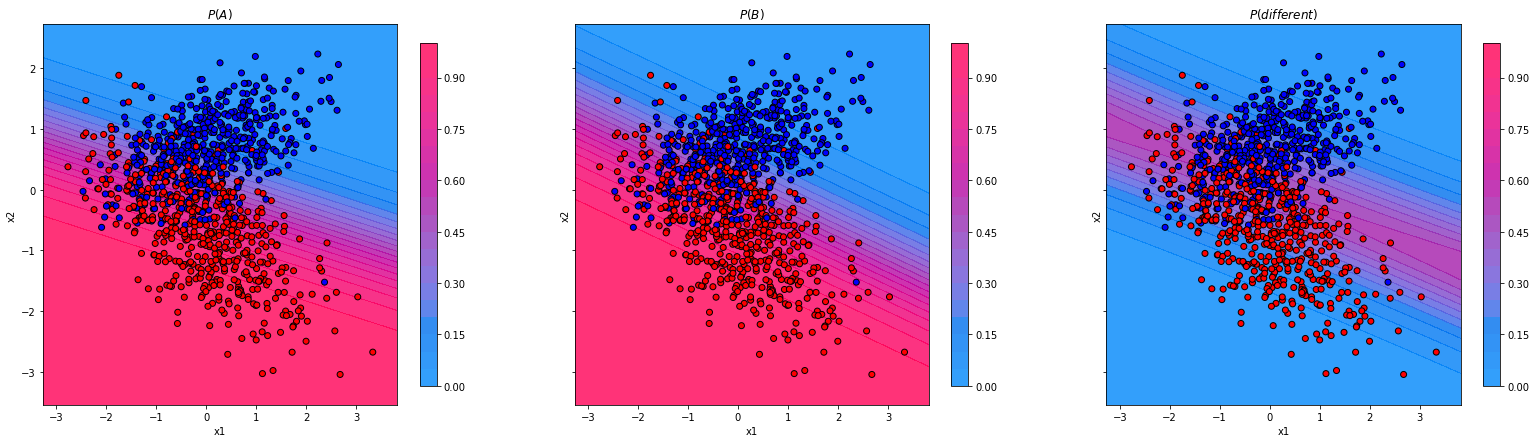

In [6]:
predict_proba_a = lambda X: clf_a.predict_proba(X)[:, 1]
predict_proba_b = lambda X: clf_b.predict_proba(X)[:, 1]
predict_proba_diff = lambda X: binary_diff_clf.predict_proba(X)[:, 0]
plot((predict_proba_a, predict_proba_b, predict_proba_diff), ('$P(A)$', '$P(B)$', '$P(different)$'))

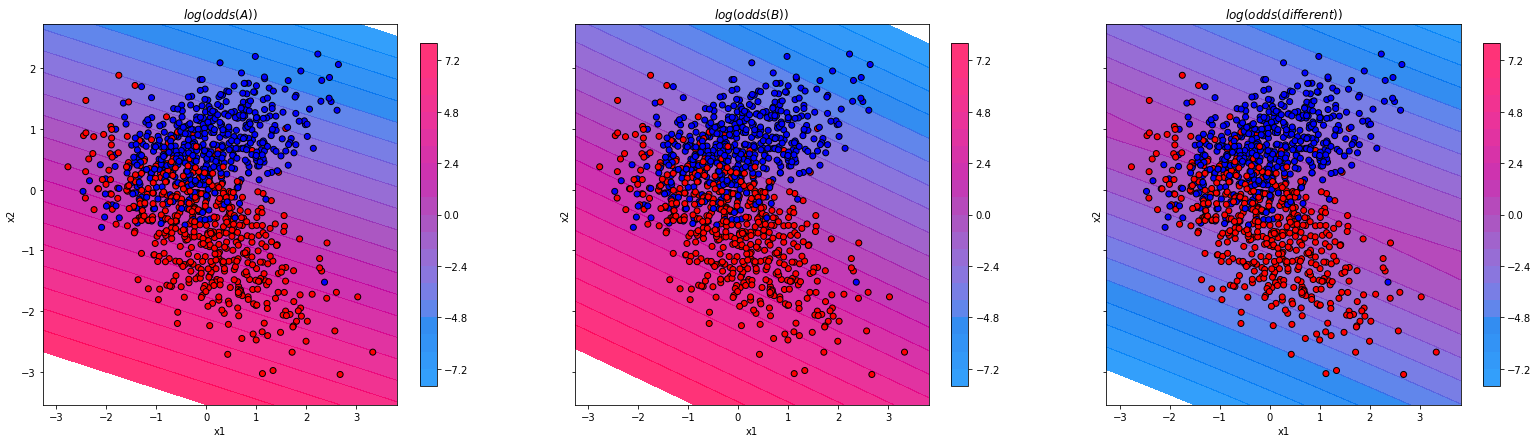

In [7]:
predict_log_odds_a = lambda X: util.calc_binary_log_odds_from_log_proba(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: util.calc_binary_log_odds_from_log_proba(clf_b.predict_log_proba(X))
predict_log_odds_diff = lambda X: -util.calc_binary_log_odds_from_log_proba(binary_diff_clf.predict_log_proba(X))
plot((predict_log_odds_a, predict_log_odds_b, predict_log_odds_diff), ('$log(odds(A))$', '$log(odds(B))$', '$log(odds(different))$'), zlim=(-8, 8))

## Visualize Distributions of Predictions

In [114]:
n_sample = X.shape[0]
indices = np.array(range(n_samples))
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
proba_a = clf_a.predict_proba(X)
proba_b = clf_b.predict_proba(X)
log_odds_a = util.calc_binary_log_odds_from_log_proba(clf_a.predict_log_proba(X))
log_odds_b = util.calc_binary_log_odds_from_log_proba(clf_b.predict_log_proba(X))

In [115]:
is_finite = np.isfinite(log_odds_a) & np.isfinite(log_odds_b)

Instances with non-finite log-odds predictions:

In [116]:
pd.DataFrame(X[~is_finite]).describe()

,0,1
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [117]:
log_odds_a[~np.isfinite(log_odds_a)]

array([], dtype=float64)

In [118]:
log_odds_b[~np.isfinite(log_odds_b)]

array([], dtype=float64)

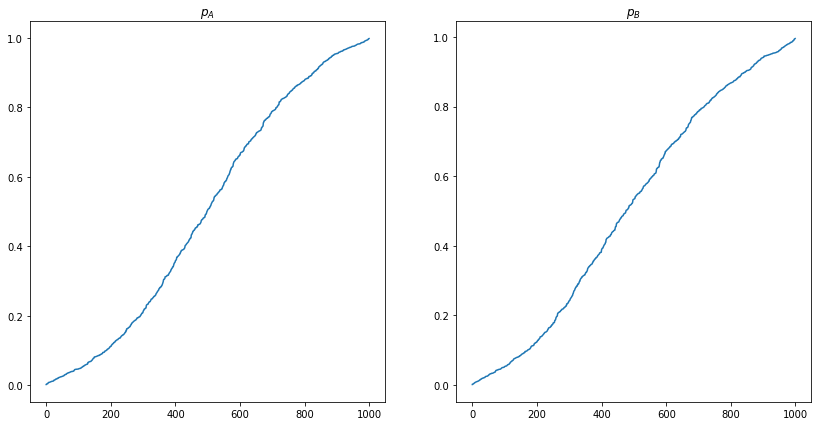

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(sorted(proba_a[:, 1]))
ax2.set_title('$p_B$')
ax2.plot(sorted(proba_b[:, 1]));

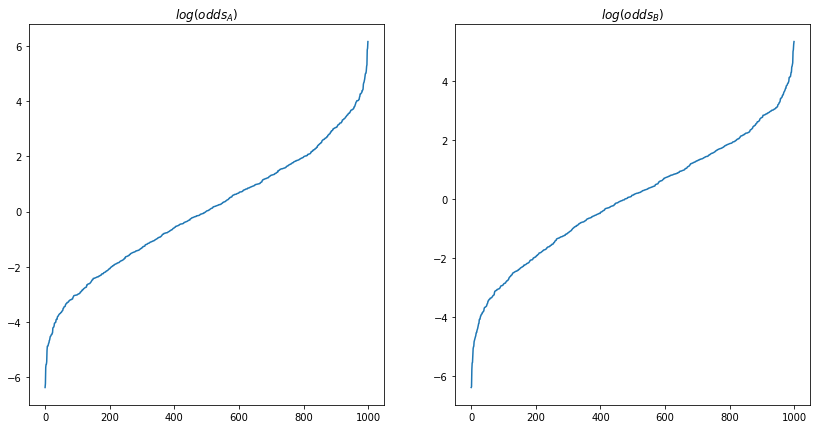

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(sorted(log_odds_a))
ax2.set_title('$log(odds_B)$')
ax2.plot(sorted(log_odds_b));

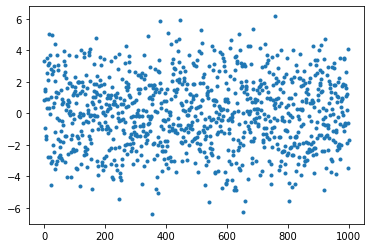

In [121]:
plt.scatter(indices, log_odds_a, marker='.');

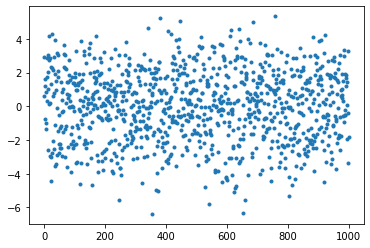

In [122]:
plt.scatter(indices, log_odds_b, marker='.');